# Classification models and feature selection
In this notebook, we train some classification models based on the thread level features. Then we use the weights in the linear models to select the most related features in detecting rumour.
The steps include:
1. Load dependancies
2. Read the thread level features from the csv file containing the samples for each event
3. Define some classification models to be trained
4. Train and test the models on the dataset:
    4.1. Decide on the train data and the test data
    4.2. Train and test 

## Load dependencies for this Jupyter Notebook
We need the function to read the thread level csv files. We also need to plot the results. Some classification models from Scikit Learn are also imported.

In [1]:
# Load dependencies for this Jupyter Notebook
import pandas as pd
import time
import numpy as np
from functools import reduce
from lib.util import fetch_thread
import matplotlib.pyplot as plt

import seaborn as sns

#Train and Test preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Classifiers:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

### Read CSV file for thread level features and separate is_rumor tag with data:
For each event, fetch the thread level features and store them in a dictionary. 

In [3]:
events=[
            "germanwings-crash",
            "sydneysiege",
            "ottawashooting",
            "ferguson",
            "charliehebdo",
        ]

events_threads={}
for event in events:
    X,y=fetch_thread(event)
    X=X.drop(X.columns.values[np.where(np.isnan(X.values))[1]],axis=1)
    events_threads[event]={'X':X.values,'y':y.values,'columns':X.columns}

### Used functions:
* **test_models**: given a list of classification models and train/test data, train the models on the data and report the train and test accuracy.
* **split_train_and_test_data**: given the names of some of the events for training and testing, split the data into train and test data:
    * If an event should go in both the train and test data, split the data in that event into 75% train data and 25% test data. 
    * If an event should go in only train or test data, store all the samples in that event in the respective train or test set.

In [4]:
def test_models(models,X_train, X_test, y_train, y_test):
    for model_name in models:
        model=models[model_name]
        model.fit(X_train,y_train)
        y_test_hat=model.predict(X_test)
        print('%s train accuracy:' % model_name, np.mean(model.predict(X_train)==y_train))
        print('%s test accuracy:' % model_name, np.mean(y_test_hat==y_test))
        print()
        
def split_train_and_test_data(train_events,test_events):
    d=events_threads[train_events[0]]['X'].shape[1]
    X_train=np.zeros((0,d))
    X_test=np.zeros((0,d))
    y_train=np.zeros((0))
    y_test=np.zeros((0))
    for event in train_events:
        if event in test_events:
            X_train1, X_test1, y_train1, y_test1 = train_test_split(events_threads[event]['X'], events_threads[event]['y'], test_size=0.25, random_state=1)
            X_train=np.concatenate((X_train,X_train1),axis=0)
            y_train=np.concatenate((y_train,y_train1),axis=None)  
            X_test=np.concatenate((X_test,X_test1),axis=0)
            y_test=np.concatenate((y_test,y_test1),axis=None)
        else:
            X_train=np.concatenate((X_train,events_threads[event]['X']),axis=0)
            y_train=np.concatenate((y_train,events_threads[event]['y']),axis=0)


    for event in test_events:
        if event not in train_events:
            X_test=np.concatenate((X_test,events_threads[event]['X']),axis=0)
            y_test=np.concatenate((y_test,events_threads[event]['y']),axis=0)

    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train=le.transform(y_train)
    y_test=le.transform(y_test)
    return X_train, X_test, y_train, y_test


## Testing different Classification Models on Different parts of dataset
### Models dictionary:

In [5]:
models={
    'LinearSVC_with_L1_Regularization' : svm.LinearSVC(penalty='l1',dual=False,max_iter=3000),
    'linear_SVM':svm.SVC(gamma='scale', kernel='linear'),
    'SVM_with_RBF_kernel': svm.SVC(gamma='scale', kernel='rbf'),
    'SVM_with_sigmoid_kernel' : svm.SVC(gamma='scale', kernel='sigmoid'),
    'KNN_with_k=5':KNeighborsClassifier(n_neighbors=5),
    'Decision_Tree_Classifier':DecisionTreeClassifier(random_state=0),
    'Random_Forest_Classifier_n=100_maxDepth=3':RandomForestClassifier(n_estimators=100, max_depth=3, random_state=4),
    'AdaBoost_n=100':AdaBoostClassifier(n_estimators=100),
    'Gaussian_Process_Classifier':GaussianProcessClassifier(1.0 * RBF(1.0)),
}

### 1. Train and test on the *charliehebdo* event:
This is the largest event.

In [6]:
X_train, X_test, y_train, y_test=split_train_and_test_data(['charliehebdo'],['charliehebdo'])
test_models(models,X_train, X_test, y_train, y_test)

LinearSVC_with_L1_Regularization train accuracy: 0.820786142571619
LinearSVC_with_L1_Regularization test accuracy: 0.8023952095808383

linear_SVM train accuracy: 0.8254497001998667
linear_SVM test accuracy: 0.8023952095808383

SVM_with_RBF_kernel train accuracy: 0.8307794803464357
SVM_with_RBF_kernel test accuracy: 0.7764471057884231

SVM_with_sigmoid_kernel train accuracy: 0.7581612258494337
SVM_with_sigmoid_kernel test accuracy: 0.7445109780439122

KNN_with_k=5 train accuracy: 0.8294470353097935
KNN_with_k=5 test accuracy: 0.7445109780439122

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.7784431137724551

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.7968021319120586
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.782435129740519

AdaBoost_n=100 train accuracy: 0.9127248500999334
AdaBoost_n=100 test accuracy: 0.8283433133732535

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy: 

### 2. Train and test on the *charliehebdo* and *sydneysiege* events:

In [7]:
X_train, X_test, y_train, y_test=split_train_and_test_data(['sydneysiege','charliehebdo'],['sydneysiege','charliehebdo'])
test_models(models,X_train, X_test, y_train, y_test)

C:\Users\steph\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC_with_L1_Regularization train accuracy: 0.7470588235294118
LinearSVC_with_L1_Regularization test accuracy: 0.7396226415094339

linear_SVM train accuracy: 0.7373949579831933
linear_SVM test accuracy: 0.70062893081761

SVM_with_RBF_kernel train accuracy: 0.819327731092437
SVM_with_RBF_kernel test accuracy: 0.7257861635220125

SVM_with_sigmoid_kernel train accuracy: 0.66890756302521
SVM_with_sigmoid_kernel test accuracy: 0.6792452830188679

KNN_with_k=5 train accuracy: 0.815546218487395
KNN_with_k=5 test accuracy: 0.7119496855345911

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.7345911949685534

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.7521008403361344
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.7320754716981132

AdaBoost_n=100 train accuracy: 0.8495798319327731
AdaBoost_n=100 test accuracy: 0.7685534591194969

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy: 0.66

### 3. Train on the *ferguson* and testing on *sydneysiege* events:

In [8]:
X_train, X_test, y_train, y_test=split_train_and_test_data(['germanwings-crash'],['ottawashooting'])
test_models(models,X_train, X_test, y_train, y_test)

LinearSVC_with_L1_Regularization train accuracy: 0.8197530864197531
LinearSVC_with_L1_Regularization test accuracy: 0.456242707117853

linear_SVM train accuracy: 0.8444444444444444
linear_SVM test accuracy: 0.4620770128354726

SVM_with_RBF_kernel train accuracy: 0.8839506172839506
SVM_with_RBF_kernel test accuracy: 0.48774795799299886

SVM_with_sigmoid_kernel train accuracy: 0.6419753086419753
SVM_with_sigmoid_kernel test accuracy: 0.5344224037339557

KNN_with_k=5 train accuracy: 0.7506172839506173
KNN_with_k=5 test accuracy: 0.5215869311551925

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.5414235705950992

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.8419753086419753
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.5379229871645275

AdaBoost_n=100 train accuracy: 1.0
AdaBoost_n=100 test accuracy: 0.558926487747958

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy: 0.501750291715

### 4. Train and test on all of the events:

In [9]:
X_train, X_test, y_train, y_test=split_train_and_test_data(events,events)
test_models(models,X_train, X_test, y_train, y_test)

LinearSVC_with_L1_Regularization train accuracy: 0.6991670749632533
LinearSVC_with_L1_Regularization test accuracy: 0.6608058608058608

linear_SVM train accuracy: 0.692062714355708
linear_SVM test accuracy: 0.652014652014652

SVM_with_RBF_kernel train accuracy: 0.8233708966193043
SVM_with_RBF_kernel test accuracy: 0.6886446886446886

SVM_with_sigmoid_kernel train accuracy: 0.6215090641842235
SVM_with_sigmoid_kernel test accuracy: 0.6043956043956044

KNN_with_k=5 train accuracy: 0.8027927486526213
KNN_with_k=5 test accuracy: 0.6798534798534799

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.6813186813186813

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.6876531112199902
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.6586080586080586

AdaBoost_n=100 train accuracy: 0.7895639392454679
AdaBoost_n=100 test accuracy: 0.7289377289377289

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy: 

### 5. Train on all of the events except *germanwings-crash* event and test on *germanwings-crash* event:

In [10]:
X_train, X_test, y_train, y_test=split_train_and_test_data(["sydneysiege","ottawashooting","ferguson","charliehebdo"]
                                    ,["germanwings-crash"])
test_models(models,X_train, X_test, y_train, y_test)

LinearSVC_with_L1_Regularization train accuracy: 0.706862356207854
LinearSVC_with_L1_Regularization test accuracy: 0.5580246913580247

linear_SVM train accuracy: 0.6923839746132487
linear_SVM test accuracy: 0.5530864197530864

SVM_with_RBF_kernel train accuracy: 0.8216977389924633
SVM_with_RBF_kernel test accuracy: 0.4839506172839506

SVM_with_sigmoid_kernel train accuracy: 0.6380404601348671
SVM_with_sigmoid_kernel test accuracy: 0.5135802469135803

KNN_with_k=5 train accuracy: 0.8040460134867117
KNN_with_k=5 test accuracy: 0.5111111111111111

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.5185185185185185

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.7046806822689409
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.5012345679012346

AdaBoost_n=100 train accuracy: 0.7949226497421658
AdaBoost_n=100 test accuracy: 0.4839506172839506

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy:

### 6. Train on all of the events and test on *ottawashooting* event:

In [11]:
X_train, X_test, y_train, y_test=split_train_and_test_data(events
                                    ,["ottawashooting"])
test_models(models,X_train, X_test, y_train, y_test)

LinearSVC_with_L1_Regularization train accuracy: 0.7008792048929664
LinearSVC_with_L1_Regularization test accuracy: 0.5023255813953489

linear_SVM train accuracy: 0.6880733944954128
linear_SVM test accuracy: 0.4790697674418605

SVM_with_RBF_kernel train accuracy: 0.8207186544342507
SVM_with_RBF_kernel test accuracy: 0.6

SVM_with_sigmoid_kernel train accuracy: 0.6267201834862385
SVM_with_sigmoid_kernel test accuracy: 0.46511627906976744

KNN_with_k=5 train accuracy: 0.7996941896024465
KNN_with_k=5 test accuracy: 0.5953488372093023

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.6139534883720931

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.6821483180428135
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.49767441860465117

AdaBoost_n=100 train accuracy: 0.786697247706422
AdaBoost_n=100 test accuracy: 0.6232558139534884

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy: 0.6139534883

### 7. Train on all of the events except *ferguson* event and test on *ferguson* event:

In [12]:
X_train, X_test, y_train, y_test=split_train_and_test_data(["germanwings-crash","sydneysiege","ottawashooting","charliehebdo"]
                                    ,["ferguson"])
test_models(models,X_train, X_test, y_train, y_test)

LinearSVC_with_L1_Regularization train accuracy: 0.6912328149650665
LinearSVC_with_L1_Regularization test accuracy: 0.6356435643564357

linear_SVM train accuracy: 0.6864998873112463
linear_SVM test accuracy: 0.6613861386138614

SVM_with_RBF_kernel train accuracy: 0.830290736984449
SVM_with_RBF_kernel test accuracy: 0.6663366336633664

SVM_with_sigmoid_kernel train accuracy: 0.5997295469912103
SVM_with_sigmoid_kernel test accuracy: 0.5801980198019802

KNN_with_k=5 train accuracy: 0.7942303358124859
KNN_with_k=5 test accuracy: 0.5524752475247525

Decision_Tree_Classifier train accuracy: 1.0
Decision_Tree_Classifier test accuracy: 0.49306930693069306

Random_Forest_Classifier_n=100_maxDepth=3 train accuracy: 0.7099391480730223
Random_Forest_Classifier_n=100_maxDepth=3 test accuracy: 0.6049504950495049

AdaBoost_n=100 train accuracy: 0.7881451431147172
AdaBoost_n=100 test accuracy: 0.499009900990099

Gaussian_Process_Classifier train accuracy: 1.0
Gaussian_Process_Classifier test accuracy:

## Feature selection based on the weight of the LinearSVC_with_L1_Regularization model
We find the most important features as the features that have the 15 most negative weights in the Linear SVM and the 15 most positive weights in the Linear SVM.

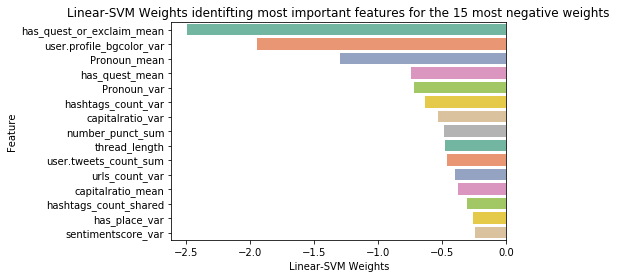

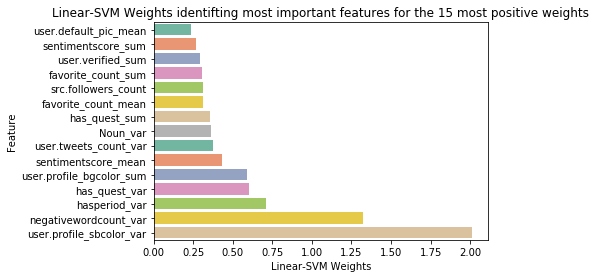

In [13]:
X_train, X_test, y_train, y_test=split_train_and_test_data(["charliehebdo"]
                                    ,["ferguson"])
model=models['linear_SVM']
model.fit(X_train,y_train)
plt.figure()
plt.title("Linear-SVM Weights identifting most important features for the 15 most negative weights")
labels = events_threads["ferguson"]["columns"].values
coefs=model.coef_.flatten()
sorted_labels = [label for _,label in sorted(zip(coefs,labels), key=lambda pair: pair[0])]
sorted_coefs=np.sort(coefs)
ax = sns.barplot(y=sorted_labels[:15], x=sorted_coefs[:15], palette="Set2")
ax.set(xlabel="Linear-SVM Weights", ylabel="Feature")
plt.show()

plt.figure()
plt.title("Linear-SVM Weights identifting most important features for the 15 most positive weights")
ax = sns.barplot(y=sorted_labels[-15:], x=sorted_coefs[-15:], palette="Set2")
ax.set(xlabel="Linear-SVM Weights", ylabel="Feature")
plt.show()